Initial dataset shape: (569, 33)
Dataset shape after cleaning: (569, 31)

Missing values per column:
 Series([], dtype: int64)

Basic statistics of the dataset:
         diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000       

<ipython-input-3-d20240726301>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['diagnosis'], palette=['skyblue', 'salmon'])


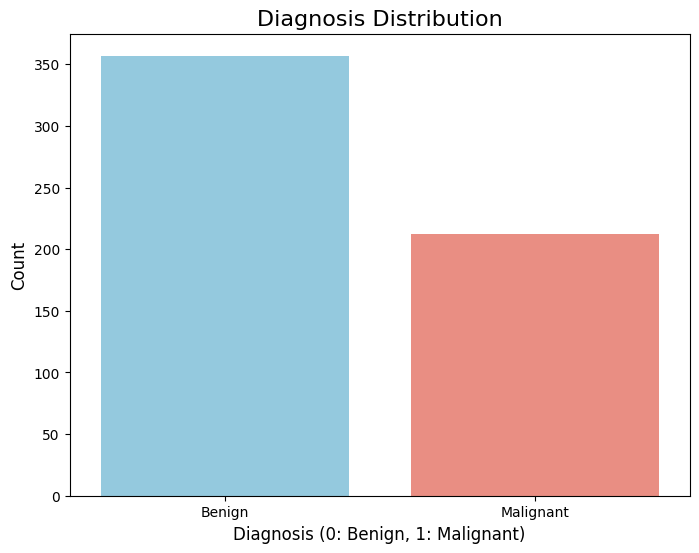

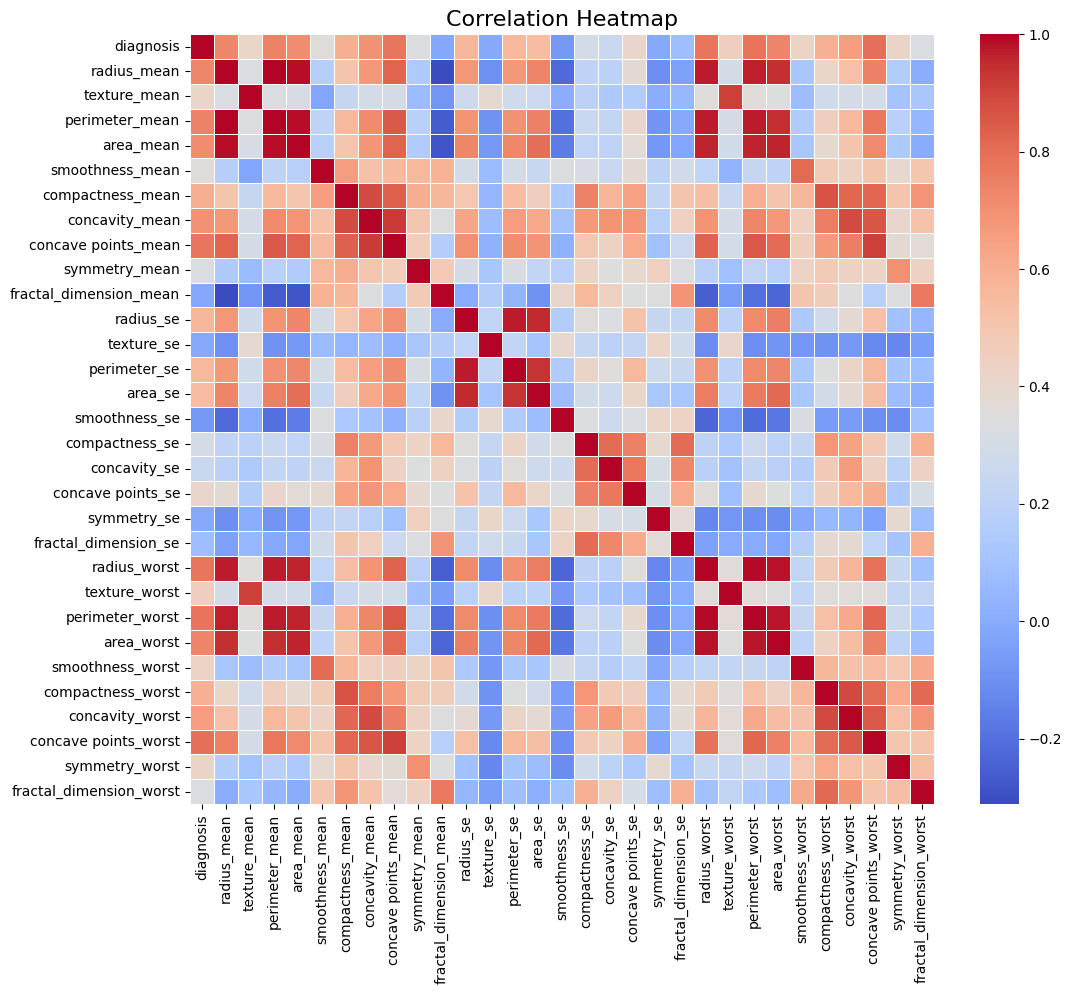


Performing Grid Search for Random Forest...

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Model Evaluation:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



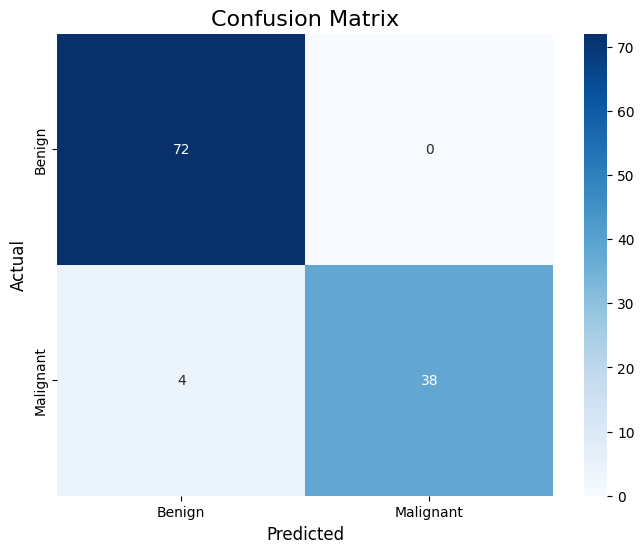

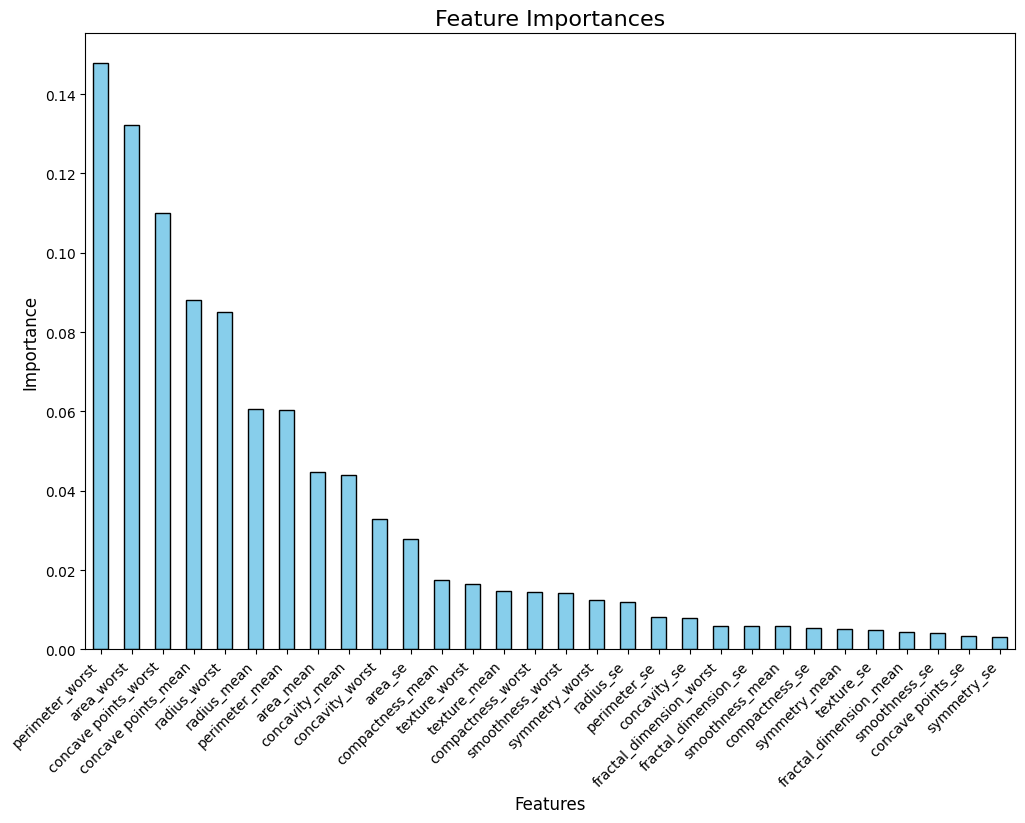

Model saved to breast_cancer_model.pkl


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Step 1: Load dataset
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Step 2: Data Cleaning
print("Initial dataset shape:", data.shape)

# Drop unnecessary columns if they exist
drop_cols = ['id', 'Unnamed: 32']
data = data.drop(columns=[col for col in drop_cols if col in data.columns])

# Encode diagnosis: M = 1 (Malignant), B = 0 (Benign)
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

print("Dataset shape after cleaning:", data.shape)

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:\n", missing_values[missing_values > 0])

# Step 3: Data Exploration
print("\nBasic statistics of the dataset:\n", data.describe())

# Plot target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=data['diagnosis'], palette=['skyblue', 'salmon'])
plt.title('Diagnosis Distribution', fontsize=16)
plt.xlabel('Diagnosis (0: Benign, 1: Malignant)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# Step 4: Split features and target
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Train Random Forest with Hyperparameter Tuning
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_model, param_grid, scoring='roc_auc', cv=3, verbose=0)
print("\nPerforming Grid Search for Random Forest...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Predictions and Evaluation
print("\nModel Evaluation:")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['Benign', 'Malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Feature Importance
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Step 7: Save the model
model_path = 'breast_cancer_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")
